In [1]:
### Package imports ###

#from ray import tune
import time
import logging
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import darts 
from sklearn.svm import SVR
from darts.models import RegressionModel
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import TransformedTargetRegressor
import pickle

import warnings
warnings.filterwarnings("ignore")

In [2]:

#AutoPatchTST

### Ignore warnings ###

logging.getLogger("pytorch_lightning").setLevel(logging.WARNING)
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
os.environ["TUNE_DISABLE_STRICT_METRIC_CHECKING"] = "1"

### Data preprocessing ###


def load_data(file_path):
    df = (pd.read_csv(file_path)
          .rename(columns={"year_quarter": "ds", "GDPC1": "y"})
          .assign(unique_id=np.ones(len(pd.read_csv(file_path))),
                  ds=lambda df: pd.to_datetime(df['ds'])))
    columns_order = ["unique_id", "ds", "y"] + \
        [col for col in df.columns if col not in ["unique_id", "ds", "y"]]
    #df['ds'] = df['ds'] - pd.Timedelta(days=1)
    return df[columns_order]


def separate_covariates(df, point_in_time):
    covariates = df.drop(columns=["unique_id", "ds", "y"])

    if not point_in_time:
        return df[covariates.columns], df[[]]

    mask = covariates.apply(
        lambda col: col.loc[col.index >= point_in_time - 1].isnull().any())

    past_covariates = df[mask.index[mask]]
    future_covariates = df[mask.index[~mask]]

    return past_covariates, future_covariates


def impute_missing_values_interpolate(data, method='linear'):
    imputed_data = data.copy()
    imputed_data.fillna(method='bfill', inplace=True)
    return imputed_data.interpolate(method=method)

def variable_screening(p,n,target_df,pc_df,fc_df):
#We screen variables based on the first n quarters.    
#We compute the correlation between the first n entries of the target_df and the covariates which are 
#separated into past and future covariates according to the separate_covariates function    
    target_tr_df = np.array(target_df.iloc[:n,2])
    pc_tr_df = np.array(pc_df.iloc[:n,:])
    fc_tr_df = np.array(fc_df.iloc[:n,:])

    pc_cors = np.array([np.abs(np.corrcoef(target_tr_df,pc_tr_df[:,i])[0,1]) for i in range(pc_tr_df.shape[1])])
    fc_cors = np.array([np.abs(np.corrcoef(target_tr_df,fc_tr_df[:,i])[0,1]) for i in range(fc_tr_df.shape[1])])

#Throw away all variables with absolute correlation <= p. The past and/or future covariates could be empty.
    pc_ind = np.where(pc_cors > p)[0]
    pc_empty = np.any(pc_ind)
    fc_ind = np.where(fc_cors > p)[0]
    fc_empty = np.any(fc_ind)

    np_pc = np.array(pc_df)[:,pc_ind]
    np_fc = np.array(fc_df)[:,fc_ind]

#convert everything to Darts time series objects. I always throw away the last entry in the target series...This corresponds 
#to the value we want to forecaast.
    target_series = darts.TimeSeries.from_times_and_values(times=pd.DatetimeIndex(target_df["ds"]),values=np.array(target_df["y"]))
#the .drop_after method throws way everything after and including the split point
    target_series = target_series.drop_after(target_series.time_index[len(target_series)-1])
    
    if(pc_empty): pc_series = darts.TimeSeries.from_times_and_values(times=pd.DatetimeIndex(target_df["ds"]),values=np_pc)
    else: pc_series = []

    if(fc_empty): fc_series =  darts.TimeSeries.from_times_and_values(times=pd.DatetimeIndex(target_df["ds"]),values=np_fc)
    else: fc_series = []

    return target_series, pc_series, fc_series, pc_empty, fc_empty

vintage_files = [
    f'../../../data/FRED/blocked/vintage_{year}_{month:02d}.csv'
    for year in range(2018, 2024)
    for month in range(1, 13)
    if not (
        (year == 2018 and month < 5) or
        (year == 2023 and month > 5)
    )
] 



In [16]:
def forecast_vintage(vintage_file):
   
    df = load_data(vintage_file)
    target_df = df[["unique_id", "ds", "y"]]
    

    point_in_time = df.index[-2] # explain later
    target_date = target_df['ds'].iloc[-1]
    
    past_covariates, future_covariates = separate_covariates(df, point_in_time)

    pc_df = impute_missing_values_interpolate(past_covariates)
    fc_df = impute_missing_values_interpolate(future_covariates)
#I assign nan to the last values of the target series and past covariates.
#Just a check against any sort of data leakage.
    target_df.iloc[target_df.shape[0]-1,2] = np.nan
    pc_df.iloc[target_df.shape[0]-1,:] = np.nan

#select 20% of the data for validation
    val_size = int(0.2*(pc_df.shape[0]-1))
    tr_size = pc_df.shape[0] -1 - val_size
    date_time = pd.DatetimeIndex(target_df["ds"])
    val_start = date_time[tr_size]

#Initialize the grids for the hyper-parameter tuning.
    target_lags = [-1,-2,-3]
    pc_lags = [-1,-2]
    fc_lags = [0,-1]
    cost_grid = [2**-9,2**-7,2**-5,2**-3,0.5]
    s_grid = [0.3,0.4,0.5,0.6,0.7]
    eps = 1.0
    err_mat = np.ones([len(target_lags),len(pc_lags),len(fc_lags),len(cost_grid),len(s_grid)])
    
    for t in range(err_mat.shape[0]):
        for p in range(err_mat.shape[1]):
            for f in range(err_mat.shape[2]):
                for c in range(err_mat.shape[3]):
                    for s in range(err_mat.shape[4]):

                        target_series, pc_series, fc_series, pc_empty, fc_empty = variable_screening(p=s_grid[s],n=tr_size,target_df=target_df,pc_df=pc_df,fc_df=fc_df)

                        if(pc_empty & fc_empty):
                            #Our base model is SVR where all the covariates and response are normalized. 
                            #I used the sklearn pipe to avoid any data leakage.
                            base_mod = SVR(kernel='linear',C=cost_grid[c],epsilon=eps)
                            wrapped_model = TransformedTargetRegressor(regressor=base_mod, transformer=StandardScaler())
                            pipeline = [('scaler',StandardScaler()),('svr',wrapped_model)]
                            reg_model = Pipeline(pipeline)

                            model = RegressionModel(lags=target_lags[:(t+1)], lags_future_covariates = fc_lags[:(f+1)],
                                                        lags_past_covariates=pc_lags[:(p+1)],output_chunk_length=1,
                                                        model=reg_model)
                                #Here I compute the historical forecasts, backtesting, temporal cross-validation, whatever you want to call it.
                                #Note that the historical forecasts are computed over a period that was not used in the variable screening process.
                            temp_cv = model.historical_forecasts(series=target_series, past_covariates=pc_series, future_covariates=fc_series, 
                                                       start=val_start, forecast_horizon=1, stride=1, retrain=True,verbose=False)

                        if(pc_empty == True & fc_empty == False):
                                #case when there are no future covariates
                            base_mod = SVR(kernel='linear',C=cost_grid[c],epsilon=eps)
                            wrapped_model = TransformedTargetRegressor(regressor=base_mod, transformer=StandardScaler())
                            pipeline = [('scaler',StandardScaler()),('svr',wrapped_model)]
                            reg_model = Pipeline(pipeline)

                            model = RegressionModel(lags=target_lags[:(t+1)], lags_future_covariates = fc_lags[:(f+1)],
                                                        lags_past_covariates=pc_lags[:(p+1)],output_chunk_length=1,
                                                        model=reg_model)
     
                            temp_cv = model.historical_forecasts(series=target_series, past_covariates=pc_series,start=val_start, 
                                                         forecast_horizon=1, stride=1, retrain=True,verbose=False)
     
                        if(pc_empty == False & fc_empty == True):
                                 #case when there are no past covariates
                            base_mod = SVR(kernel='linear',C=cost_grid[c],epsilon=eps)
                            wrapped_model = TransformedTargetRegressor(regressor=base_mod, transformer=StandardScaler())
                            pipeline = [('scaler',StandardScaler()),('svr',wrapped_model)]
                            reg_model = Pipeline(pipeline)

                            model = RegressionModel(lags=target_lags[:(t+1)], lags_future_covariates = fc_lags[:(f+1)],
                                                        lags_past_covariates=pc_lags[:(p+1)],output_chunk_length=1,
                                                        model=reg_model)
     
                            temp_cv = model.historical_forecasts(series=target_series, future_covariates=fc_series,start=val_start,
                                                          forecast_horizon=1, stride=1, retrain=True,verbose=False)
     

                        err_mat[t,p,f,c,s] =  darts.metrics.metrics.rmse(actual_series=target_series, pred_series=temp_cv)   
                        #print(t,p,f,c,s,err_mat[t,p,f,c,s],np.amin(err_mat))
    
    #find best hyper parameters.
    loc = np.where(err_mat == np.amin(err_mat))
    t,p,f,c,s = loc[0][0], loc[1][0], loc[2][0], loc[3][0], loc[4][0], 
    print(t,p,f,c,s)

    n = (target_df.shape[0]-1)
    #screen away variables using all available data, fit model and forecast.
    target_series, pc_series, fc_series, pc_empty, fc_empty = variable_screening(p=s_grid[s],n=n,target_df=target_df,pc_df=pc_df,fc_df=fc_df)

    if(pc_empty & fc_empty):
        base_mod = SVR(kernel='linear',C=cost_grid[c],epsilon=eps)
        wrapped_model = TransformedTargetRegressor(regressor=base_mod, transformer=StandardScaler())
        pipeline = [('scaler',StandardScaler()),('svr',wrapped_model)]
        reg_model = Pipeline(pipeline)

        model = RegressionModel(lags=target_lags[:(t+1)], lags_future_covariates = fc_lags[:(f+1)],
                                                        lags_past_covariates=pc_lags[:(p+1)],output_chunk_length=1,
                                                        model=reg_model)
        model.fit(series=target_series,past_covariates=pc_series,future_covariates=fc_series)     
                         

    if(pc_empty == True & fc_empty == False):
        base_mod = SVR(kernel='linear',C=cost_grid[c],epsilon=eps)
        wrapped_model = TransformedTargetRegressor(regressor=base_mod, transformer=StandardScaler())
        pipeline = [('scaler',StandardScaler()),('svr',wrapped_model)]
        reg_model = Pipeline(pipeline)

        model = RegressionModel(lags=target_lags[:(t+1)], lags_future_covariates = fc_lags[:(f+1)],
                                                        lags_past_covariates=pc_lags[:(p+1)],output_chunk_length=1,
                                                        model=reg_model)
    
        model.fit(series=target_series, past_covariates=pc_series)
     
                              
     
    if(pc_empty == False & fc_empty == True):
        base_mod = SVR(kernel='linear',C=cost_grid[c],epsilon=eps)
        wrapped_model = TransformedTargetRegressor(regressor=base_mod, transformer=StandardScaler())
        pipeline = [('scaler',StandardScaler()),('svr',wrapped_model)]
        reg_model = Pipeline(pipeline)

        model = RegressionModel(lags=target_lags[:(t+1)], lags_future_covariates = fc_lags[:(f+1)],
                                                        lags_past_covariates=pc_lags[:(p+1)],output_chunk_length=1,
                                                        model=reg_model)
    
        model.fit(series=target_series, future_covariates=fc_series)
    

    #return all the relevant results in a dictionary.

    return {'target_date':target_date,'vintage_date':vintage_file[27:42],'forecast':model.predict(n=1).univariate_values()[0],'historical_forecasts_errors':err_mat,
            'target lags':target_lags[:(t+1)],"fc lags":fc_lags[:(f+1)],"pc lags":pc_lags[:(p+1)],"cost":cost_grid[c],"thres":s_grid[s]}
    

In [17]:
#run over all vintages
results = []

for i in range(len(vintage_files)):
    print(vintage_files[i])
    results.append(forecast_vintage(vintage_files[i]))
    

../../../data/FRED/blocked/vintage_2018_05.csv
2 0 1 1 2
../../../data/FRED/blocked/vintage_2018_06.csv
0 0 0 2 2
../../../data/FRED/blocked/vintage_2018_07.csv
0 0 0 3 3
../../../data/FRED/blocked/vintage_2018_08.csv
1 0 1 1 0
../../../data/FRED/blocked/vintage_2018_09.csv
0 0 0 2 1
../../../data/FRED/blocked/vintage_2018_10.csv
0 0 0 3 3
../../../data/FRED/blocked/vintage_2018_11.csv
1 0 1 1 0
../../../data/FRED/blocked/vintage_2018_12.csv
0 0 0 2 1
../../../data/FRED/blocked/vintage_2019_01.csv
0 0 1 1 1
../../../data/FRED/blocked/vintage_2019_02.csv
2 0 1 1 2
../../../data/FRED/blocked/vintage_2019_03.csv
0 0 0 2 1
../../../data/FRED/blocked/vintage_2019_04.csv
0 0 0 3 3
../../../data/FRED/blocked/vintage_2019_05.csv
1 0 1 1 1
../../../data/FRED/blocked/vintage_2019_06.csv
0 0 0 2 1
../../../data/FRED/blocked/vintage_2019_07.csv
0 0 0 3 3
../../../data/FRED/blocked/vintage_2019_08.csv
0 0 1 1 0
../../../data/FRED/blocked/vintage_2019_09.csv
0 0 0 2 1
../../../data/FRED/blocked/vint

In [ ]:
#with open('linear_results.pickle', 'wb') as handle:
#    pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [34]:
with open('linear_results.pickle', 'rb') as handle:
    results = pickle.load(handle)

vintage_names = [i["vintage_date"] for i in results]
forecasts = [i["forecast"] for i in results]
dt = [results[j]['target_date'] for j in range(len(results))] 

out = pd.DataFrame({"ds":dt,"vintage_file":vintage_names,"Estimate":forecasts,"Model":"SVR_LINEAR"})
out.to_csv("linear_svr_forecasts")


In [81]:
#Store forecasts and targets
results.pop()
results_dataframe = pd.DataFrame(np.array([j['forecast'] for j in results]).reshape([20,3]),columns=["Month1","Month2","Month3"])

dt = [results[j]['target_date'] for j in range(0,60,3)]

results_dataframe = results_dataframe.set_index(pd.DatetimeIndex(dt))

df = load_data(vintage_files[len(vintage_files)-1])
target_df = pd.DataFrame(df["y"])
results_dataframe["Target"] = np.array(target_df.iloc[[np.where(df["ds"] == results_dataframe.index[j])[0][0] for j in range(results_dataframe.shape[0])]])


In [83]:
#compute some metrics
rmse = []
r2_score = []

rmse.append(darts.metrics.metrics.rmse(actual_series=darts.TimeSeries.from_series(results_dataframe["Target"]), pred_series=darts.TimeSeries.from_series(results_dataframe["Month1"]))) 
r2_score.append(darts.metrics.metrics.r2_score(actual_series=darts.TimeSeries.from_series(results_dataframe["Target"]), pred_series=darts.TimeSeries.from_series(results_dataframe["Month1"])))  
rmse.append(darts.metrics.metrics.rmse(actual_series=darts.TimeSeries.from_series(results_dataframe["Target"]), pred_series=darts.TimeSeries.from_series(results_dataframe["Month2"])))  
r2_score.append(darts.metrics.metrics.r2_score(actual_series=darts.TimeSeries.from_series(results_dataframe["Target"]), pred_series=darts.TimeSeries.from_series(results_dataframe["Month2"])))  
rmse.append(darts.metrics.metrics.rmse(actual_series=darts.TimeSeries.from_series(results_dataframe["Target"]), pred_series=darts.TimeSeries.from_series(results_dataframe["Month3"])))  
r2_score.append(darts.metrics.metrics.r2_score(actual_series=darts.TimeSeries.from_series(results_dataframe["Target"]), pred_series=darts.TimeSeries.from_series(results_dataframe["Month3"])))  

print(rmse)
print(r2_score)

[0.013600379550522613, 0.00905501526631714, 0.005600968295569054]
[0.7470762280807357, 0.8878844203684958, 0.9571042938559593]


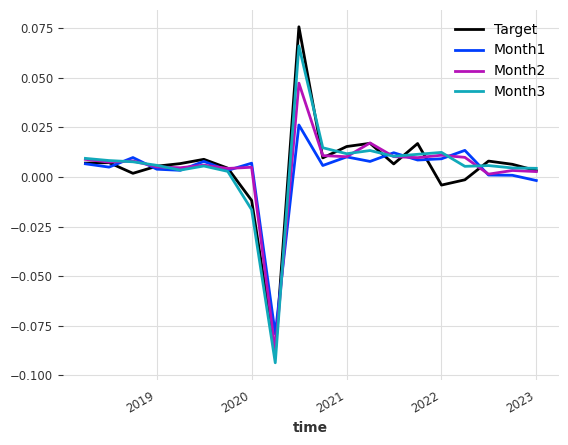

In [84]:
darts.TimeSeries.from_series(results_dataframe["Target"]).plot()
darts.TimeSeries.from_series(results_dataframe["Month1"]).plot()
darts.TimeSeries.from_series(results_dataframe["Month2"]).plot()
darts.TimeSeries.from_series(results_dataframe["Month3"]).plot()